# HW3
---
*deadline: 05/25/2022 11:59 PM*

Using transformers library solve the sentiment classification task.

In this homework you should explore sentiment task; make a simple classifier with BERT embeddings to predict if the hypothesis is entailed from the premise text or not; finetune BERT-based model on sentiment task; make LM model and again finetune on the classification task; compare the results of classifiers and describe your results.

## Dataset acknowledgement

### Installs and impoorts

In [ ]:
!pip install datasets
!pip install transformers
!pip install -U sentence-transformers
!pip install bert-embedding
!pip install mxnet-cu100

     |████████████████████████████████| 325 kB 5.3 MB/s 
     |████████████████████████████████| 136 kB 52.2 MB/s 
     |████████████████████████████████| 212 kB 49.2 MB/s 
     |████████████████████████████████| 1.1 MB 34.2 MB/s 
     |████████████████████████████████| 77 kB 6.1 MB/s 
     |████████████████████████████████| 127 kB 39.4 MB/s 
     |████████████████████████████████| 271 kB 40.2 MB/s 
     |████████████████████████████████| 94 kB 3.1 MB/s 
     |████████████████████████████████| 144 kB 42.4 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.
     |████████████████████████████████| 4.0 MB 5.1 MB/s 


     |████████████████████████████████| 354.0 MB 4.8 kB/s 
     |████████████████████████████████| 15.7 MB 34.7 MB/s 
  Attempting uninstall: numpy
    Found existing installation: numpy 1.14.6
    Uninstalling numpy-1.14.6:
      Successfully uninstalled numpy-1.14.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.8.0 requires tf-estimator-nightly==2.8.0.dev2021122109, which is not installed.
mxnet 1.4.0 requires numpy<1.15.0,>=1.8.2, but you have numpy 1.21.6 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.
bert-embedding 1.0.1 requires numpy==1.14.6, but you have numpy 1.21.6 which is incompatible.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [ ]:
import datasets

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from transformers import BertTokenizer, BertConfig, BertForTokenClassification
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AdamW, AutoModelForSeq2SeqLM,  AutoModelForTokenClassification, BertModel

import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

Download IMDB dataset

In [ ]:
ds = datasets.load_dataset("imdb")

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

Dataset imdb downloaded and prepared to /root/.cache/huggingface/datasets/imdb/plain_text/1.0.0/2fdd8b9bcadd6e7055e742a706876ba43f19faee861df134affd7a3f60fc38a1. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

### Dataset summary

Create train and test dataframes

In [ ]:
train, test = ds["train"], ds["test"]
train_data = pd.DataFrame(train)
test_data = pd.DataFrame(test)

In [ ]:
train_data.head()

,text,label
0,I rented I AM CURIOUS-YELLOW from my video sto...,0
1,"""I Am Curious: Yellow"" is a risible and preten...",0
2,If only to avoid making this type of film in t...,0
3,This film was probably inspired by Godard's Ma...,0
4,"Oh, brother...after hearing about this ridicul...",0


In [ ]:
test_data.head()

,text,label
0,I love sci-fi and am willing to put up with a ...,0
1,"Worth the entertainment value of a rental, esp...",0
2,its a totally average film with a few semi-alr...,0
3,STAR RATING: ***** Saturday Night **** Friday ...,0
4,"First off let me say, If you haven't enjoyed a...",0


Dataset common info

In [ ]:
train_data.info(), train_data.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    25000 non-null  object
 1   label   25000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 390.8+ KB


(None, (25000, 2))

In [ ]:
test_data.info(), test_data.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    25000 non-null  object
 1   label   25000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 390.8+ KB


(None, (25000, 2))

In [ ]:
 train_label_count = train_data.label.value_counts()
 train_label_count

0    12500
1    12500
Name: label, dtype: int64

In [ ]:
 test_label_count = test_data.label.value_counts()
 test_label_count

0    12500
1    12500
Name: label, dtype: int64

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: Non-1D inputs to pie() are currently squeeze()d, but this behavior is deprecated since 3.1 and will be removed in 3.3; pass a 1D array instead.
  # This is added back by InteractiveShellApp.init_path()


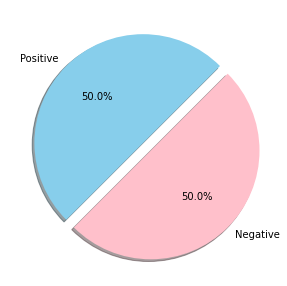

In [ ]:
fig = plt.figure(figsize=(5,5))
colors = ["skyblue",'pink']
pos = train[train['label']==1]
neg = train[train['label']==0]
ck = [label_count]
piechart = plt.pie(ck,labels=["Positive","Negative"],
                 autopct ='%1.1f%%',
                 shadow = True,
                 colors = colors,
                 startangle = 45,
                 explode=(0, 0.1))


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 0, 'label')

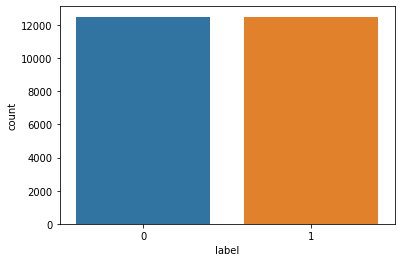

In [ ]:
sns.countplot(train_data.label)
plt.xlabel('label')

Check sentence len distribution

(array([2., 1., 2., ..., 0., 0., 1.]),
 array([  10,   11,   12, ..., 2468, 2469, 2470]),
 <a list of 2460 Patch objects>)

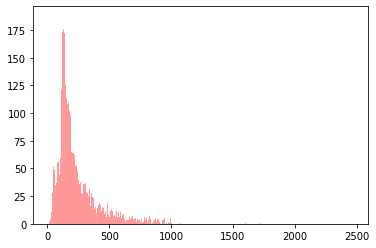

In [ ]:
sentences = [len(sent.split()) for sent in train_data['text']]

#plt.rcParams.update({'figure.figsize':(7,5), 'figure.dpi':100})
plt.hist(sentences, bins=range(min(sentences), max(sentences) + 1, 1), 
              alpha=0.4, color="red")
#plt.gca().set(title='No. of characters in each sentence', xlabel='Number of sentence', ylabel='Number of Characters in each sentence');

In [ ]:
sent = np.array(sentences)
sent.mean()

233.7872

In [ ]:
max([len(sent) for sent in train_data['text']])

13704

In [ ]:
#token_lens = []

#for txt in train_data.text:
#  tokens = tokenizer.encode(txt, max_length=512)
#  token_lens.append(len(tokens))

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


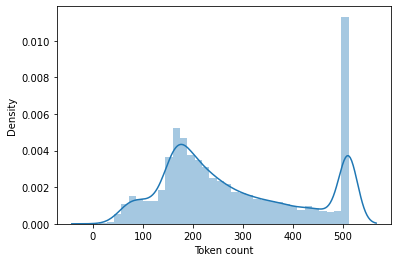

In [ ]:
sns.distplot(token_lens)
#plt.xlim([0, 256]);
plt.xlabel('Token count');
None

## Text preprocessig

### Import and installs

In [ ]:
import os
import random
import numpy as np
import pandas as pd
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
from nltk.tokenize import sent_tokenize, word_tokenize 
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer 
from nltk.corpus import wordnet
from nltk.tag import pos_tag
import re
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_curve, auc
from matplotlib import pyplot as plt
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
import itertools
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import mxnet as mx
from bert_embedding import BertEmbedding
from sentence_transformers import SentenceTransformer
import gensim 
from gensim.models import Word2Vec 

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [ ]:
def NormalizeWithPOS(text):
    # Lemmatization & Stemming according to POS tagging

    word_list = word_tokenize(text)
    rev = []
    lemmatizer = WordNetLemmatizer() 
    stemmer = PorterStemmer() 
    for word, tag in pos_tag(word_list):
        if tag.startswith('J'):
            w = lemmatizer.lemmatize(word, pos='a')
        elif tag.startswith('V'):
            w = lemmatizer.lemmatize(word, pos='v')
        elif tag.startswith('N'):
            w = lemmatizer.lemmatize(word, pos='n')
        elif tag.startswith('R'):
            w = lemmatizer.lemmatize(word, pos='r')
        else:
            w = word
        w = stemmer.stem(w)
        rev.append(w)
    review = ' '.join(rev)
    return review

In [ ]:
def cleanText(text):
    
    text = re.sub(r'<.*?>', ' ', text)
    text = re.sub(r"won't", "will not", text)
    text = re.sub(r"can't", "can not", text)
    text = re.sub(r"n't", " not", text)
    text = re.sub(r"'ve", " have", text)
    text = re.sub(r"'ll", " will", text)
    text = re.sub(r"'re", " are", text)

    if embedding is not 'BERT':
        text = re.sub(r"[0-9]+", ' ', text)
        text = re.sub(r"-", ' ', text)
    
    
    text = text.strip().lower()
    
    if embedding is 'WORD2VEC_NO_STOP':
        # Remove Stop words
        default_stop_words = set(stopwords.words('english'))
        default_stop_words.difference_update({'no', 'not', 'nor', 'too', 'any'})
        stop_words = default_stop_words.union({"'m", "n't", "'d", "'re", "'s",
                                               'would','must',"'ve","'ll",'may'})
    
        word_list = word_tokenize(text)
        filtered_list = [w for w in word_list if not w in stop_words]
        text = ' '.join(filtered_list)
    
    if embedding is not 'BERT':
        # Remove other contractions
        text = re.sub(r"'", ' ', text)
    
    # Replace punctuations with space
    if embedding is 'BERT': # save ! ? . for end of the sentence detection [,/():;']
        filters='"#$%&*+<=>@[\\]^_`{|}~\t\n'
        text = re.sub(r'\!+', '!', text)
        text = re.sub(r'\?+', '?', text)
    else:
        filters='!"\'#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n'
    translate_dict = dict((i, " ") for i in filters)
    translate_map = str.maketrans(translate_dict)
    text = text.translate(translate_map)
    
    if embedding is 'BERT':
        text = re.sub(r'\( *\)', ' ', text)

    if embedding is not 'BERT':
        text = ' '.join([w for w in text.split() if len(w)>1])

    # Replace multiple space with one space
    text = re.sub(' +', ' ', text)
    
    text = ''.join(text)

    return text

In [ ]:
embedding = ''
# for Word2Vec with stop words
train_data['clean_text'] = train_data['text'].apply(cleanText)
test_data['clean_text'] = test_data['text'].apply(cleanText)

In [ ]:
# for BOW and TFIDF(s)
train_data['clean_text_normalized'] = train_data['clean_text'].apply(NormalizeWithPOS)
test_data['clean_text_normalized'] = test_data['clean_text'].apply(NormalizeWithPOS)

In [ ]:
freq_train = pd.Series(' '.join(train_data['clean_text_normalized']).split()).value_counts()
less_five_freq_train = freq_train[(freq_train <5)]
print(less_five_freq_train)

passé         4
pierrot       4
shortland     4
milder        4
radiu         4
             ..
mwuhahahaa    1
bellwood      1
autumn       1
jetlin        1
dunni         1
Length: 30510, dtype: int64


In [ ]:
freq_test = pd.Series(' '.join(test_data['clean_text_normalized']).split()).value_counts()
less_five_freq_test = freq_test[(freq_test <5)]
print(less_five_freq_test)

mellencamp    4
cuoco         4
haskel        4
contrit       4
crooner       4
             ..
naura         1
dowson        1
tabanga       1
blaisdel      1
oxymoron      1
Length: 29987, dtype: int64


In [ ]:
train_data['clean_text_normalized'] = train_data['clean_text_normalized'].apply(lambda x: ' '.join(x for x in x.split() if x not in less_five_freq_train))
test_data['clean_text_normalized'] = test_data['clean_text_normalized'].apply(lambda x: ' '.join(x for x in x.split() if x not in less_five_freq_test))

In [ ]:
embedding = 'WORD2VEC_NO_STOP'
# for Word2Vec without stop words
train_data['clean_text_w2v_no_stop'] = train_data['text'].apply(cleanText)
test_data['clean_text_w2v_no_stop'] = test_data['text'].apply(cleanText)

In [ ]:
embedding = 'BERT'
# for BERT(s)
train_data['clean_text_bert'] = train_data['text'].apply(cleanText)
test_data['clean_text_bert'] = test_data['text'].apply(cleanText)

In [ ]:
train_data.to_csv('prep_train.csv', sep="\t")
test_data.to_csv('prep_test.csv', sep="\t")


In [ ]:
train_data = pd.read_csv("/content/drive/MyDrive/HW3/prep_train.csv", sep='\t')
test_data = pd.read_csv("/content/drive/MyDrive/HW3/prep_test.csv", sep='\t')


In [ ]:
def mean(z): # used for BERT (word version) and Word2Vec
    return sum(itertools.chain(z))/len(z)

In [ ]:
embedding = 'BOW'
vectorizer = CountVectorizer(stop_words='english')

bow_training_features = vectorizer.fit_transform(train_data["clean_text_normalized"])    
bow_test_features = vectorizer.transform(test_data["clean_text_normalized"])

print(bow_training_features.shape)

(25000, 19368)


In [ ]:
embedding = 'TFIDF_WITH_STOP'
vectorizer = TfidfVectorizer(ngram_range=(1, 2), max_features=20000)

tfidf_with_stop_training_features = vectorizer.fit_transform(train_data["clean_text_normalized"])    
tfidf_with_stop_test_features = vectorizer.transform(test_data["clean_text_normalized"])

print(tfidf_with_stop_training_features.shape)

(25000, 20000)


In [ ]:
embedding = 'TFIDF_NO_STOP'
vectorizer = TfidfVectorizer(stop_words='english', ngram_range=(1, 2), max_features=20000)

tfidf_no_stop_training_features = vectorizer.fit_transform(train_data["clean_text_normalized"])    
tfidf_no_stop_test_features = vectorizer.transform(test_data["clean_text_normalized"])

print(tfidf_no_stop_training_features.shape)

(25000, 20000)


In [ ]:
def embeddToBERT(text):
    sentences = re.split('!|\?|\.',text)
    sentences = list(filter(None, sentences)) 

    if bert_version == 'WORD':
        result = bert(sentences, 'avg') # avg is refer to handle OOV
    
        bert_vocabs_of_sentence = []
        for sentence in range(len(result)):
            for word in range(len(result[sentence][1])):
                bert_vocabs_of_sentence.append(result[sentence][1][word])
        feature = [mean(x) for x in zip(*bert_vocabs_of_sentence)]

    elif bert_version == 'SENTENCE':
        result = bert_transformers.encode(sentences)
        feature = [mean(x) for x in zip(*result)]
  
    return feature

In [ ]:
ctx = mx.gpu(0)
bert = BertEmbedding(ctx=ctx)

In [ ]:
bert_version = 'WORD'
bert_word_training_features = train_data['clean_text_bert'].apply(embeddToBERT)
bert_word_test_features = test_data['clean_text_bert'].apply(embeddToBERT)

In [ ]:
feature = [x for x in bert_word_training_features.transpose()]
bert_word_training_features = np.asarray(feature)

feature = [x for x in bert_word_test_features.transpose()]
bert_word_test_features = np.asarray(feature)

print(bert_word_training_features.shape)

In [ ]:
bert_transformers = SentenceTransformer('bert-base-nli-mean-tokens')

In [ ]:
bert_version = 'SENTENCE'
bert_sentence_training_features = train_data['clean_text_bert'].apply(embeddToBERT)
bert_sentence_test_features = test_data['clean_text_bert'].apply(embeddToBERT)

In [ ]:
feature = [x for x in bert_sentence_training_features.transpose()]
bert_sentence_training_features = np.asarray(feature)

feature = [x for x in bert_sentence_test_features.transpose()]
bert_sentence_test_features = np.asarray(feature)

print(bert_sentence_training_features.shape)

## **Part 0. [1 point] Get embeddings**
Take any BERT model and get BERT embeddings from the train dataset (or train + dev).

We will use "bert-base-cased" model

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")  #("sberbank-ai/bert-base-NER-reptile-5-datasets")
model = BertModel.from_pretrained("bert-base-cased")

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/208k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/426k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/416M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
from tqdm import tqdm

Embeddings for train data from last hidden states of BERT model

In [ ]:
last_ft = pd.DataFrame(columns = np.arange(0, 768))
for sentence in tqdm(train_data['text']):
    encoding = tokenizer(sentence, add_special_tokens = True,    truncation = True, padding = "max_length", return_attention_mask = True, return_tensors = "pt")
    with torch.no_grad():
        b = pd.DataFrame()
        last_hidden_states = model(**encoding)
        a = pd.DataFrame(last_hidden_states[0][:,0,:].numpy(), columns = np.arange(0, 768))
        last_ft = last_ft.append(a)
        #print(features)
        

100%|██████████| 1/1 [00:03<00:00,  3.27s/it]


Example of embedding

In [ ]:
last_ft

,0,1,2,3,4,5,6,7,8,9,...,758,759,760,761,762,763,764,765,766,767
0,0.490654,0.052071,0.004661,-0.121135,0.15557,0.279539,0.209194,-0.13568,-0.075614,-1.106859,...,0.403127,0.311755,-0.309614,-0.172688,0.197899,-0.102961,-0.049814,-0.592337,0.31466,0.121195


In [ ]:
last_ft.to_csv("/content/drive/MyDrive/HW3/features_3_2.csv", sep="\t")

Embeddings for test data from last hidden states of BERT model

In [ ]:
test_ft = pd.DataFrame(columns = np.arange(0, 768))
for sentence in tqdm(test_data['text'][20000:25000]):
    encoding = tokenizer(sentence, add_special_tokens = True,    truncation = True, padding = "max_length", return_attention_mask = True, return_tensors = "pt")
    with torch.no_grad():
        #b = pd.DataFrame()
        last_hidden_states = model(**encoding)
        a = pd.DataFrame(last_hidden_states[0][:,0,:].numpy(), columns = np.arange(0, 768))
        test_ft = test_ft.append(a)
        #print(features)
        

100%|██████████| 5000/5000 [2:34:50<00:00,  1.86s/it]


In [ ]:
test_ft.to_csv("/content/drive/MyDrive/HW3/features_5.csv", sep="\t")

Read our extracted features

In [ ]:
ft = pd.read_csv("/content/drive/MyDrive/HW3/features.csv", sep="\t")

In [ ]:
ft.columns

Index(['Unnamed: 0', '0', '1', '2', '3', '4', '5', '6', '7', '8',
       ...
       '758', '759', '760', '761', '762', '763', '764', '765', '766', '767'],
      dtype='object', length=769)

In [ ]:
res = ft.drop(['Unnamed: 0'], axis=1)

In [ ]:
a = pd.read_csv("/content/drive/MyDrive/HW3/train_features/features.csv", sep="\t")
b = pd.read_csv("/content/drive/MyDrive/HW3/train_features/features_1_2.csv", sep="\t")
c = pd.read_csv("/content/drive/MyDrive/HW3/train_features/features_2.csv", sep="\t")
d = pd.read_csv("/content/drive/MyDrive/HW3/train_features/features_2_2.csv", sep="\t")
e = pd.read_csv("/content/drive/MyDrive/HW3/train_features/features_3.csv", sep="\t")
f = pd.read_csv("/content/drive/MyDrive/HW3/train_features/features_3_2.csv", sep="\t")
g = pd.read_csv("/content/drive/MyDrive/HW3/train_features/features_4.csv", sep="\t")


In [ ]:
data = pd.concat([a, b, c, d, e, f, g])

In [ ]:
new = np.arange(0, 25000)
d = data.set_index(new)
d = d.drop('Unnamed: 0', axis=1)
d

,0,1,2,3,4,5,6,7,8,9,...,758,759,760,761,762,763,764,765,766,767
0,0.478648,-0.203076,-0.373453,-0.186025,-0.114815,-0.198142,0.454825,-0.221537,-0.035297,-1.048143,...,0.083342,0.328200,-0.365786,-0.124352,0.244855,0.327898,-0.130168,-0.205778,0.164381,0.287931
1,0.548120,-0.100279,-0.038858,-0.055771,-0.002016,-0.069875,0.420663,-0.277535,0.047127,-1.353825,...,0.311314,0.145523,-0.193353,0.033737,0.107445,0.185187,-0.129532,-0.356209,0.086276,-0.095223
2,0.572075,-0.008198,0.058231,-0.157280,-0.130591,0.070381,0.228235,-0.114001,0.126726,-1.267575,...,0.512474,0.346401,-0.305159,0.112855,0.195282,0.010355,0.090522,-0.307933,0.111299,-0.039345
3,0.650412,0.199456,-0.258077,-0.192962,0.139154,-0.231237,0.286449,-0.230282,-0.186003,-1.126615,...,0.176404,0.153094,-0.320333,-0.163887,-0.015377,0.093841,0.015943,-0.135931,0.257048,0.109638
4,0.501262,0.161152,-0.178206,-0.217147,-0.051396,-0.018234,0.339371,-0.177433,-0.018948,-1.178050,...,0.212604,0.209317,-0.105043,0.000518,0.066666,0.191762,-0.065845,-0.397228,0.181945,0.027946
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24995,0.897292,-0.022400,-0.089900,-0.433419,0.269236,0.037131,0.399054,0.009604,-0.220075,-1.181652,...,0.036668,0.162514,-0.182875,-0.261198,0.012830,0.075587,0.184886,-0.061462,0.191115,-0.014555
24996,0.994611,0.103479,-0.005015,-0.113412,0.220416,0.194759,0.248863,0.013735,-0.303064,-0.989122,...,0.391348,0.068725,-0.223186,-0.084816,0.131006,-0.052374,0.362629,-0.068430,0.230143,0.161017
24997,0.795936,0.165877,-0.165345,-0.326659,0.208492,-0.159097,0.660948,-0.108373,-0.311419,-1.048536,...,0.288148,0.006377,-0.245803,0.032806,0.109651,0.242337,0.445559,0.048999,0.067434,0.180006
24998,0.472434,0.092889,-0.337821,-0.131989,-0.061577,0.017565,0.247862,-0.077549,0.225337,-1.270845,...,0.644827,0.271783,-0.143085,0.257209,0.121598,0.028006,0.264542,-0.217514,0.124865,0.098917


In [ ]:
d.to_csv("/content/drive/MyDrive/HW3/train_features.csv", sep="\t")

## **Part 1. [2 point] Explore your data**
-  Make a 2D reduction and draw plot for train labels.
-  Analyze your results.

### Preparations

In [ ]:
res = pd.read_csv("/content/drive/MyDrive/HW3/train_features/train_features.csv", sep="\t")

Fix seed and create permutations for PCA and t-SNE 2D reduction

In [ ]:
np.random.seed(42)
rndperm = np.random.permutation(res.shape[0])

In [ ]:
res

,Unnamed: 0,0,1,2,3,4,5,6,7,8,...,758,759,760,761,762,763,764,765,766,767
0,0,0.478648,-0.203076,-0.373453,-0.186025,-0.114815,-0.198142,0.454825,-0.221537,-0.035297,...,0.083342,0.328200,-0.365786,-0.124352,0.244855,0.327898,-0.130168,-0.205778,0.164381,0.287931
1,1,0.548120,-0.100279,-0.038858,-0.055771,-0.002016,-0.069875,0.420663,-0.277535,0.047127,...,0.311314,0.145523,-0.193353,0.033737,0.107445,0.185187,-0.129532,-0.356209,0.086276,-0.095223
2,2,0.572075,-0.008198,0.058231,-0.157280,-0.130591,0.070381,0.228235,-0.114001,0.126726,...,0.512474,0.346401,-0.305159,0.112855,0.195282,0.010355,0.090522,-0.307933,0.111299,-0.039345
3,3,0.650412,0.199456,-0.258077,-0.192962,0.139154,-0.231237,0.286449,-0.230282,-0.186003,...,0.176404,0.153094,-0.320333,-0.163887,-0.015377,0.093841,0.015943,-0.135931,0.257048,0.109638
4,4,0.501262,0.161152,-0.178206,-0.217147,-0.051396,-0.018234,0.339371,-0.177433,-0.018948,...,0.212604,0.209317,-0.105043,0.000518,0.066666,0.191762,-0.065845,-0.397228,0.181945,0.027946
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24995,24995,0.897292,-0.022400,-0.089900,-0.433419,0.269236,0.037131,0.399054,0.009604,-0.220075,...,0.036668,0.162514,-0.182875,-0.261198,0.012830,0.075587,0.184886,-0.061462,0.191115,-0.014555
24996,24996,0.994611,0.103479,-0.005015,-0.113412,0.220416,0.194759,0.248863,0.013735,-0.303064,...,0.391348,0.068725,-0.223186,-0.084816,0.131006,-0.052374,0.362629,-0.068430,0.230143,0.161017
24997,24997,0.795936,0.165877,-0.165345,-0.326659,0.208492,-0.159097,0.660948,-0.108373,-0.311419,...,0.288148,0.006377,-0.245803,0.032806,0.109651,0.242337,0.445559,0.048999,0.067434,0.180006
24998,24998,0.472434,0.092889,-0.337821,-0.131989,-0.061577,0.017565,0.247862,-0.077549,0.225337,...,0.644827,0.271783,-0.143085,0.257209,0.121598,0.028006,0.264542,-0.217514,0.124865,0.098917


Add target label to our embeddings

In [ ]:
res['y'] = train_data['label']

In [ ]:
res2 = res.drop('Unnamed: 0', axis=1)

### Installs and imports

In [ ]:
import time
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

### PCA



In [ ]:
pca = PCA(n_components=3)
pca_result = pca.fit_transform(res2[map(str, np.arange(0, 768))].values)
res['pca-one'] = pca_result[:,0]
res['pca-two'] = pca_result[:,1] 
res['pca-three'] = pca_result[:,2]
print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

Explained variation per principal component: [0.15739557 0.08719309 0.05414144]


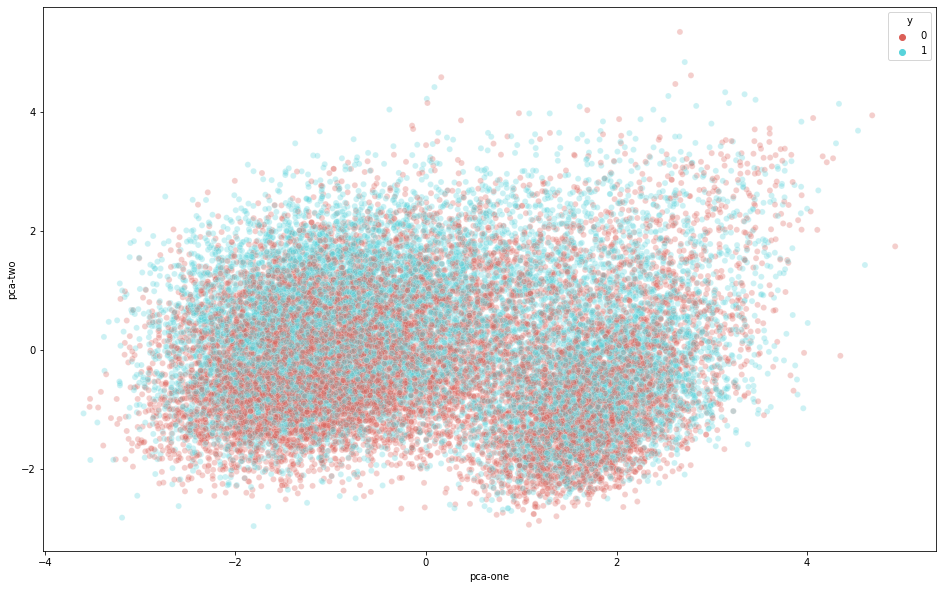

In [ ]:
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="pca-one", y="pca-two",
    hue="y",
    palette=sns.color_palette("hls", 2),
    data=res.loc[rndperm,:],
    legend="full",
    alpha=0.3
)

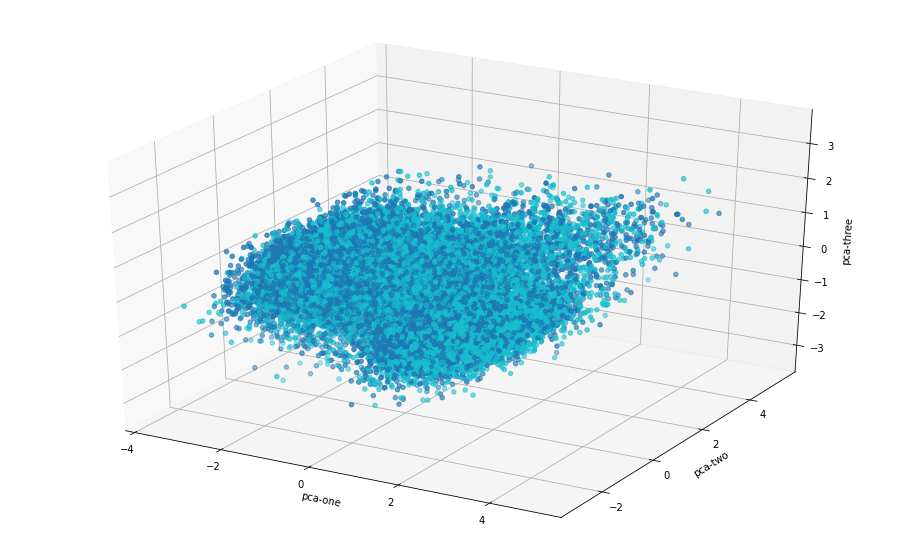

In [ ]:
ax = plt.figure(figsize=(16,10)).gca(projection='3d')
ax.scatter(
    xs=res.loc[rndperm,:]["pca-one"], 
    ys=res.loc[rndperm,:]["pca-two"], 
    zs=res.loc[rndperm,:]["pca-three"], 
    c=res.loc[rndperm,:]["y"], 
    cmap='tab10'
)
ax.set_xlabel('pca-one')
ax.set_ylabel('pca-two')
ax.set_zlabel('pca-three')
plt.show()

t-SNE

In [ ]:
#N = 10000
df_subset = res2.loc[rndperm,:].copy()
data_subset = res2[map(str, np.arange(0, 768))].values
pca = PCA(n_components=3)
pca_result = pca.fit_transform(data_subset)
df_subset['pca-one'] = pca_result[:,0]
df_subset['pca-two'] = pca_result[:,1] 
df_subset['pca-three'] = pca_result[:,2]
print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

Explained variation per principal component: [0.15739557 0.08719309 0.05414144]


In [ ]:
time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(data_subset)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 25000 samples in 0.035s...
[t-SNE] Computed neighbors for 25000 samples in 49.551s...
[t-SNE] Computed conditional probabilities for sample 1000 / 25000
[t-SNE] Computed conditional probabilities for sample 2000 / 25000
[t-SNE] Computed conditional probabilities for sample 3000 / 25000
[t-SNE] Computed conditional probabilities for sample 4000 / 25000
[t-SNE] Computed conditional probabilities for sample 5000 / 25000
[t-SNE] Computed conditional probabilities for sample 6000 / 25000
[t-SNE] Computed conditional probabilities for sample 7000 / 25000
[t-SNE] Computed conditional probabilities for sample 8000 / 25000
[t-SNE] Computed conditional probabilities for sample 9000 / 25000
[t-SNE] Computed conditional probabilities for sample 10000 / 25000
[t-SNE] Computed conditional probabilities for sample 11000 / 25000
[t-SNE] Computed conditional probabilities for sample 12000 / 25000
[t-SNE] Computed conditional probabilities for s

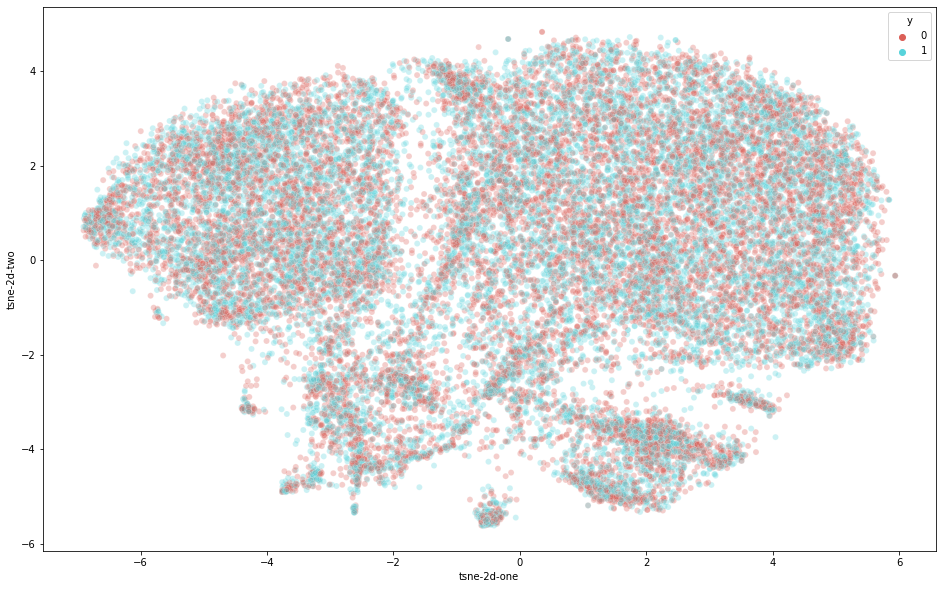

In [ ]:
df_subset['tsne-2d-one'] = tsne_results[:,0]
df_subset['tsne-2d-two'] = tsne_results[:,1]
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="y",
    palette=sns.color_palette("hls", 2),
    data=df_subset,
    legend="full",
    alpha=0.3
)

## **Part 2. [3 points] Make first classifier**
-  Use pretrained embeddings as features to classifier. You can use for example SVM or LinearRegression.
-  Evaluate yourself by test dataset labels, do not use for train!

### installs and imports

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
import torch
import transformers as ppb
import warnings
warnings.filterwarnings('ignore')

### Preparations

Split our extracted features(embeddings)

In [ ]:
train_features, test_features, train_labels, test_labels = train_test_split(res3, train_data['label'])

Use Grid Search for optimal params

In [ ]:
parameters = {'C': np.linspace(0.0001, 100, 20)}
grid_search = GridSearchCV(LogisticRegression(), parameters)
grid_search.fit(train_features, train_labels)

print('best parameters: ', grid_search.best_params_)
print('best scrores: ', grid_search.best_score_)

best parameters:  {'C': 57.89477894736842}
best scrores:  0.6873066666666666


### Logistic Regression train

In [ ]:
lr_clf = LogisticRegression()
lr_clf.fit(train_features, train_labels)

LogisticRegression()

### Regression Scores

In [ ]:
lr_clf.score(test_features, test_labels)

0.69008

In [ ]:
from sklearn.dummy import DummyClassifier
clf = DummyClassifier()

scores = cross_val_score(clf, train_features, train_labels)
print("Dummy classifier score: %0.3f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Dummy classifier score: 0.501 (+/- 0.00)


SVM train

In [ ]:
def printResult(y_pred, y_prob):
    acc = accuracy_score(test_labels, y_pred)
    # Result
    print("Accuracy: {:.2f}".format(acc*100),end='\n\n')
    cm = confusion_matrix(test_labels,y_pred)
    print('Confusion Matrix:\n', cm)
    print(classification_report(test_labels,y_pred))

    # Plot
    fpr, tpr, thresholds = roc_curve(test_labels, y_prob)
    roc_auc = auc(fpr, tpr)
    print ("Area under the ROC curve : %f" % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.plot(fpr, tpr, color='red', label='ROC curve (area = %0.2f)' % roc_auc)
    plt.legend(loc='lower right')

In [ ]:
model = SVC(kernel ='linear', C = 1)

In [ ]:
model.fit(train_features, train_labels)

# Evaluation
y_pred_bow_svm = model.predict(test_features)
y_prob_bow_svm = model.decision_function(test_features)

### SVM results

Accuracy: 68.45

Confusion Matrix:
 [[2193  951]
 [1021 2085]]
              precision    recall  f1-score   support

           0       0.68      0.70      0.69      3144
           1       0.69      0.67      0.68      3106

    accuracy                           0.68      6250
   macro avg       0.68      0.68      0.68      6250
weighted avg       0.68      0.68      0.68      6250

Area under the ROC curve : 0.736529


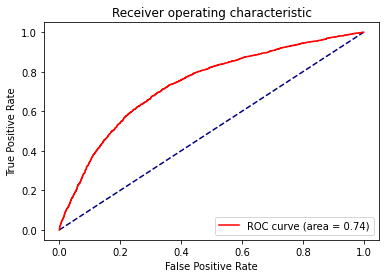

In [ ]:
printResult(y_pred_bow_svm, y_prob_bow_svm)

## **Part 3. [4 points] Finetune on Classification task**
-  Finetune on a classification task with BERT-based model you chose in the 0 part
-  Evaluate yourself by test dataset labels, do not use for train!

### Installs and imports

In [ ]:
!pip install transformers
!pip install datasets

In [ ]:
import datasets
import torch
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

from transformers import BertTokenizer, BertConfig, BertForTokenClassification
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AdamW, AutoModelForSeq2SeqLM,  AutoModelForTokenClassification, BertModel

from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

### Dataset preparations

In [ ]:
ds = datasets.load_dataset("imdb")

Reusing dataset imdb (/root/.cache/huggingface/datasets/imdb/plain_text/1.0.0/2fdd8b9bcadd6e7055e742a706876ba43f19faee861df134affd7a3f60fc38a1)


  0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
train, test = ds["train"], ds["test"]
train_data = pd.DataFrame(train)
test_data = pd.DataFrame(test)

In [ ]:
a = test_data.sample(frac=1)
a.label.value_counts()
train_data = train_data.sample(frac=1)
test_data = a

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")  #("sberbank-ai/bert-base-NER-reptile-5-datasets")
model = BertModel.from_pretrained("bert-base-cased")

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/208k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/426k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/416M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


### BERT tokenizer example

In [ ]:
#Let's see how Bertencoder is encoding a sentence
sample_txt = 'When was I last outside? I am stuck at home for 2 weeks.'
tokens = tokenizer.tokenize(sample_txt)
token_ids = tokenizer.convert_tokens_to_ids(tokens)

print(f' Sentence: {sample_txt}')
print(f'   Tokens: {tokens}')
print(f'Token IDs: {token_ids}')

 Sentence: When was I last outside? I am stuck at home for 2 weeks.
   Tokens: ['When', 'was', 'I', 'last', 'outside', '?', 'I', 'am', 'stuck', 'at', 'home', 'for', '2', 'weeks', '.']
Token IDs: [1332, 1108, 146, 1314, 1796, 136, 146, 1821, 5342, 1120, 1313, 1111, 123, 2277, 119]


In [ ]:
tokenizer.sep_token, tokenizer.sep_token_id
tokenizer.cls_token, tokenizer.cls_token_id
tokenizer.pad_token, tokenizer.pad_token_id
tokenizer.unk_token, tokenizer.unk_token_id

('[UNK]', 100)

In [ ]:
#To do all preprocessing you specify some parameters in the encod_plus() method of the tokenizer
encoding = tokenizer.encode_plus(
  sample_txt,
  max_length=32,
  add_special_tokens=True, # Add '[CLS]' and '[SEP]'
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',  # Return PyTorch tensors
)

encoding.keys()

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2291: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


dict_keys(['input_ids', 'attention_mask'])

In [ ]:
#The tokens ids list
print(len(encoding['input_ids'][0]))
encoding['input_ids'][0]

32


tensor([ 101, 1332, 1108,  146, 1314, 1796,  136,  146, 1821, 5342, 1120, 1313,
        1111,  123, 2277,  119,  102,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0])

In [ ]:
#The attentions masked tokens
print(len(encoding['attention_mask'][0]))
encoding['attention_mask']

32


tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0]])

In [ ]:
#let's see how the sentence is tokenized with bert tokenizer
tokenizer.convert_ids_to_tokens(encoding['input_ids'][0])

['[CLS]',
 'When',
 'was',
 'I',
 'last',
 'outside',
 '?',
 'I',
 'am',
 'stuck',
 'at',
 'home',
 'for',
 '2',
 'weeks',
 '.',
 '[SEP]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]']

Token distribution

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 0, 'Token count')

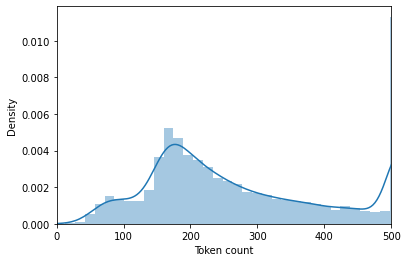

In [ ]:
token_lens = []

for txt in train_data.text:
  tokens = tokenizer.encode(txt, max_length=512)
  token_lens.append(len(tokens))
sns.distplot(token_lens)
plt.xlim([0, 500]);
plt.xlabel('Token count')

### Creating Dataset and Dataloader

Define some constants for our model

In [ ]:
MAX_LEN = 200      #for not consuming much resources
RANDOM_SEED = 42
device = torch.device( 'cuda' if torch.cuda.is_available() else 'cpu' )

Split train for validation

In [ ]:
df_train, df_val = train_test_split(train_data, test_size=0.33, random_state=RANDOM_SEED)

Create class for our dataset

In [ ]:
class IMDBDataset(Dataset):

  def __init__(self, reviews, sentiments, tokenizer, max_len):
    self.reviews = reviews
    self.sentiments = sentiments
    self.tokenizer = tokenizer
    self.max_len = max_len
  
  def __len__(self):
    return len(self.reviews)
  
  def __getitem__(self, item):
    review = str(self.reviews[item])
    sentiment = self.sentiments[item]

    encoding = self.tokenizer.encode_plus(
      review,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      pad_to_max_length=True,
      return_attention_mask=True,
      return_tensors='pt',
    )

    return {
      'review': review,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'sentiments': torch.tensor(sentiment, dtype=torch.long)
    }

Create Dataloader for model

In [ ]:
def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = IMDBDataset(
    reviews=df.text.to_numpy(),
    sentiments=df.label.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )

  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=4
  )

Define batch size and data loaders

In [ ]:
BATCH_SIZE = 16

train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(test_data, tokenizer, MAX_LEN, BATCH_SIZE)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
data = next(iter(train_data_loader))
data.keys()

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulti

dict_keys(['review', 'input_ids', 'attention_mask', 'sentiments'])

In [ ]:
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['sentiments'].shape)

torch.Size([16, 200])
torch.Size([16, 200])
torch.Size([16])


### Reviews Classification with BERT

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from transformers import AdamW, get_linear_schedule_with_warmup

Create our classifier based on BERT pretrained model

In [ ]:
class SentimentClassifier(nn.Module):

  def __init__(self, n_classes):
    super(SentimentClassifier, self).__init__()
    self.bert = BertModel.from_pretrained("bert-base-cased")
    self.drop = nn.Dropout(p=0.3)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
  
  def forward(self, input_ids, attention_mask):
    _, pooled_output = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask,
      return_dict=False
    )
    output = self.drop(pooled_output)
    return self.out(output)

In [ ]:
model = SentimentClassifier(len(train_data['label'].unique()))
model = model.to(device)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)

print(input_ids.shape) # batch size x seq length
print(attention_mask.shape) # batch size x seq length

torch.Size([16, 200])
torch.Size([16, 200])


In [ ]:
F.softmax(model(input_ids, attention_mask), dim=1)

tensor([[0.7499, 0.2501],
        [0.3583, 0.6417],
        [0.5962, 0.4038],
        [0.7464, 0.2536],
        [0.7115, 0.2885],
        [0.4424, 0.5576],
        [0.6823, 0.3177],
        [0.4729, 0.5271],
        [0.5835, 0.4165],
        [0.6880, 0.3120],
        [0.6375, 0.3625],
        [0.4904, 0.5096],
        [0.5091, 0.4909],
        [0.5518, 0.4482],
        [0.5733, 0.4267],
        [0.5383, 0.4617]], device='cuda:0', grad_fn=<SoftmaxBackward0>)

### Training (fine-tuning BERT for classification task)

Define training params

In [ ]:
EPOCHS = 4

optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


Define some helpfull functions for training and validaion

In [ ]:
def train_epoch(
  model, 
  data_loader, 
  loss_fn, 
  optimizer, 
  device, 
  scheduler, 
  n_examples
):
  model = model.train()

  losses = []
  correct_predictions = 0
  
  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    sentiments = d["sentiments"].to(device)

    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
    )

    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, sentiments)

    correct_predictions += torch.sum(preds == sentiments)
    losses.append(loss.item())

    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

  return correct_predictions.double() / n_examples, np.mean(losses)

In [ ]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()

  losses = []
  correct_predictions = 0

  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      sentiments = d["sentiments"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      loss = loss_fn(outputs, sentiments)

      correct_predictions += torch.sum(preds == sentiments)
      losses.append(loss.item())

  return correct_predictions.double() / n_examples, np.mean(losses)

In [ ]:
%%time

train_a = []
train_l = []
val_a = []
val_l = []
best_accuracy = 0

for epoch in range(EPOCHS):

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss = train_epoch(
    model,
    train_data_loader,    
    loss_fn, 
    optimizer, 
    device, 
    scheduler, 
    len(df_train)
  )

  print(f'Train loss {train_loss} accuracy {train_acc}')

  val_acc, val_loss = eval_model(
    model,
    val_data_loader,
    loss_fn, 
    device, 
    len(df_val)
  )

  print(f'Val   loss {val_loss} accuracy {val_acc}')
  print()

  train_a.append(train_acc)
  train_l.append(train_loss)
  val_a.append(val_acc)
  val_l.append(val_loss)

  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'best_model_state.bin')
    best_accuracy = val_acc

Epoch 1/4
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulti

Train loss 0.34659166561142535 accuracy 0.8471044776119403


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-s

Val   loss 0.26577886419962776 accuracy 0.8909090909090909

Epoch 2/4
----------


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-s

Train loss 0.17606212761664075 accuracy 0.9425074626865672


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-s

Val   loss 0.41623641172710035 accuracy 0.8928484848484848

Epoch 3/4
----------


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2291: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest se

Train loss 0.10454871176795166 accuracy 0.974089552238806


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2291: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest se

Val   loss 0.5288281529044684 accuracy 0.8945454545454545

Epoch 4/4
----------


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2291: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest se

Train loss 0.05714345712321672 accuracy 0.9872835820895522


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-s

Val   loss 0.5647570030624318 accuracy 0.8955151515151515

CPU times: user 48min 51s, sys: 26 s, total: 49min 17s
Wall time: 49min 35s


In [ ]:
train_accuracy = []
for i in train_a:
      train_accuracy.append(i.item())

val_accuracy = []
for i in val_a:
      val_accuracy.append(i.item())

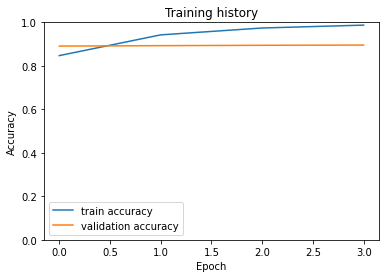

In [ ]:
plt.plot(train_accuracy, label='train accuracy')
plt.plot(val_accuracy, label='validation accuracy')

plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

In [ ]:
test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(test_data)
)

test_acc.item()

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulti

0.8960400000000001

In [ ]:
def get_predictions(model, data_loader):
  model = model.eval()
  
  review = []
  predictions = []
  prediction_probs = []
  real_values = []

  with torch.no_grad():
    for d in data_loader:

      reviews = d["review"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      sentiments = d["sentiments"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      probs = F.softmax(outputs, dim=1)

      review.extend(reviews)
      predictions.extend(preds)
      prediction_probs.extend(probs)
      real_values.extend(sentiments)

  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return review, predictions, prediction_probs, real_values

In [ ]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader
)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulti

### BERT Classifier Scores

In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
class_names = ['negative', 'positive']

In [ ]:
print(classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

    negative       0.90      0.89      0.90     12500
    positive       0.89      0.90      0.90     12500

    accuracy                           0.90     25000
   macro avg       0.90      0.90      0.90     25000
weighted avg       0.90      0.90      0.90     25000



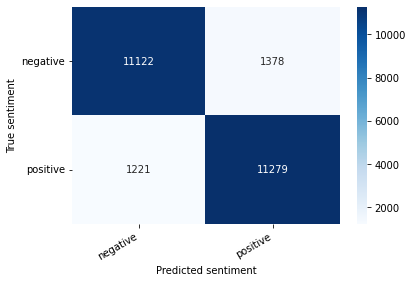

In [ ]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True sentiment')
  plt.xlabel('Predicted sentiment')

cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

In [ ]:
idx = 2

review_text = y_review_texts[idx]
true_sentiment = y_test[idx]
pred_df = pd.DataFrame({
  'class_names': class_names,
  'values': y_pred_probs[idx]
})

In [ ]:
print(review_text)
print()
print(f'True sentiment: {class_names[true_sentiment]}')

its a totally average film with a few semi-alright action sequences that make the plot seem a little better and remind the viewer of the classic van dam films. parts of the plot don't make sense and seem to be added in to use up time. the end plot is that of a very basic type that doesn't leave the viewer guessing and any twists are obvious from the beginning. the end scene with the flask backs don't make sense as they are added in and seem to have little relevance to the history of van dam's character. not really worth watching again, bit disappointed in the end production, even though it is apparent it was shot on a low budget certain shots and sections in the film are of poor directed quality

True sentiment: negative


(0.0, 1.0)

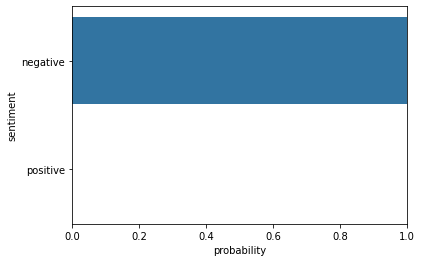

In [ ]:
sns.barplot(x='values', y='class_names', data=pred_df, orient='h')
plt.ylabel('sentiment')
plt.xlabel('probability')
plt.xlim([0, 1])

In [ ]:
saved_model = torch.load('/content/best_model_state.bin')

## **Part 4. [4 points] Finetune LM**
-  Finetune language model with BERT-based model you chose in the 0 part.
-  Draw a plot (like you did in part 0 and 1)

Let's use Hugging Face liabrary for our Language Model


### Installs and imports

In [ ]:
!pip install transformers
!pip install datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.2 MB 8.6 MB/s 
     |████████████████████████████████| 596 kB 34.1 MB/s 
     |████████████████████████████████| 84 kB 1.7 MB/s 
     |████████████████████████████████| 6.6 MB 23.7 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 346 kB 9.3 MB/s 
     |████████████████████████████████| 86 kB 2.9 MB/s 
     |████████████████████████████████| 140 kB 50.9 MB/s 
     |████████████████████████████████| 1.1 MB 38.9 MB/s 
     |████████████████████████████████| 212 kB 44.4 MB/s 
     |████████████████████████████████| 127 kB 52.7 MB/s 
     |████████████████████████████████| 144 kB 45.0 MB/s 
     |███████████████

In [ ]:
from transformers import BertTokenizer, BertForMaskedLM
import torch

tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
model = BertForMaskedLM.from_pretrained('bert-base-cased')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
import datasets
import torch
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

from transformers import BertTokenizer, BertConfig, BertForTokenClassification
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AdamW, AutoModelForSeq2SeqLM,  AutoModelForTokenClassification, BertModel

from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

In [ ]:
from tqdm import tqdm

In [ ]:
ds = datasets.load_dataset("imdb")

Reusing dataset imdb (/root/.cache/huggingface/datasets/imdb/plain_text/1.0.0/2fdd8b9bcadd6e7055e742a706876ba43f19faee861df134affd7a3f60fc38a1)


  0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
train, test = ds["train"], ds["test"]
train_data = pd.DataFrame(train)
test_data = pd.DataFrame(test)

In [ ]:
a = test_data.sample(frac=1)
a.label.value_counts()
b = train_data.sample(frac=1)
train_data = b
test_data = a

In [ ]:
train_data.head(10)

,text,label
0,I rented I AM CURIOUS-YELLOW from my video sto...,0
1,"""I Am Curious: Yellow"" is a risible and preten...",0
2,If only to avoid making this type of film in t...,0
3,This film was probably inspired by Godard's Ma...,0
4,"Oh, brother...after hearing about this ridicul...",0
5,I would put this at the top of my list of film...,0
6,Whoever wrote the screenplay for this movie ob...,0
7,"When I first saw a glimpse of this movie, I qu...",0
8,"Who are these ""They""- the actors? the filmmake...",0
9,This is said to be a personal film for Peter B...,0


### Tokenization

Create inputs for our LM

In [ ]:
inputs = tokenizer(train_data["text"].tolist(), return_tensors='pt', max_length=300, truncation=True, padding='max_length')

In [ ]:
inputs

{'input_ids': tensor([[  101,  4698,  1006,  ...,     0,     0,     0],
        [  101,  2054,  1037,  ...,     0,     0,     0],
        [  101,  5125, 11338,  ...,     0,     0,     0],
        ...,
        [  101,  1008, 27594,  ...,  4602,  2518,   102],
        [  101,  1045,  2253,  ...,     0,     0,     0],
        [  101,  1045,  2031,  ...,  2018,  2300,   102]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1]])}

### Create labels

Clone our input_ids to new labels tensor

In [ ]:
inputs['labels'] = inputs.input_ids.detach().clone()

Check our inputs dictionary

In [ ]:
inputs.keys()

dict_keys(['input_ids', 'token_type_ids', 'attention_mask', 'labels'])

### Masking

Mask a random selection of tokens in our input_ids tensor.

To create our 15% probability of masking any one token, we can use torch.rand alongside a condition of each value < 0.15. Together, these will produce our masking array mask_arr.  
-  create random array of floats with equal dimensions to input_ids tensor
-  create mask array

In [ ]:
rand = torch.rand(inputs.input_ids.shape)

mask_arr = (rand < 0.15) * (inputs.input_ids != 101) * \
           (inputs.input_ids != 102) * (inputs.input_ids != 0)

In [ ]:
mask_arr

tensor([[False, False, False,  ..., False, False, False],
        [False,  True, False,  ..., False, False, False],
        [False, False,  True,  ..., False, False, False],
        ...,
        [False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False]])

Now, we use mask_arr to select where to place our MASK tokens — but we don’t want to place a MASK token over other special tokens such as CLS or SEP tokens (101 and 102 respectively).

So, we need to add an additional condition. A check for positions containing the token ids 101 or 102.

In [ ]:
(inputs.input_ids != 101) * (inputs.input_ids != 102)

In [ ]:
mask_arr = (rand < 0.15) * (inputs.input_ids != 101) * (inputs.input_ids != 102)
mask_arr

Now that is our masking tensor, to apply it we will first extract the index positions where we find a True value — then use this selection to set values in these positions to 103 (the MASK token id).

In [ ]:
selection = []

for i in range(inputs.input_ids.shape[0]):
    selection.append(
        torch.flatten(mask_arr[i].nonzero()).tolist()
    )

In [ ]:
for i in range(inputs.input_ids.shape[0]):
    inputs.input_ids[i, selection[i]] = 103
inputs.input_ids

tensor([[  101,  4698,  1006,  ...,     0,     0,     0],
        [  101,   103,  1037,  ...,     0,     0,     0],
        [  101,  5125,   103,  ...,     0,     0,     0],
        ...,
        [  101,  1008, 27594,  ...,  4602,  2518,   102],
        [  101,  1045,  2253,  ...,     0,     0,     0],
        [  101,  1045,  2031,  ...,  2018,  2300,   102]])

### Training

In [ ]:
class IMDBDataset(torch.utils.data.Dataset):
    def __init__(self, encodings):
        self.encodings = encodings
    def __getitem__(self, idx):
        return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
    def __len__(self):
        return len(self.encodings.input_ids)

In [ ]:
dataset = IMDBDataset(inputs)

In [ ]:
loader = torch.utils.data.DataLoader(dataset, batch_size=16, shuffle=True)

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
# and move our model over to the selected device
model.to(device)
# activate training mode
model.train()

BertForMaskedLM(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=Tr

In [ ]:
from transformers import AdamW

optim = AdamW(model.parameters(), lr=5e-5)

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


In [ ]:
epochs = 2

for epoch in range(epochs):
    # setup loop with TQDM and dataloader
    loop = tqdm(loader, leave=True)
    for batch in loop:
        # initialize calculated gradients (from prev step)
        optim.zero_grad()
        # pull all tensor batches required for training
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        # process
        outputs = model(input_ids, attention_mask=attention_mask,
                        labels=labels)
        # extract loss
        loss = outputs.loss
        # calculate loss for every parameter that needs grad update
        loss.backward()
        # update parameters
        optim.step()
        # print relevant info to progress bar
        loop.set_description(f'Epoch {epoch}')
        loop.set_postfix(loss=loss.item())

  0%|          | 0/1563 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """
Epoch 1: 100%|██████████| 1563/1563 [30:12<00:00,  1.16s/it, loss=0.188]


### PCA

In [ ]:
max_length=512

In [ ]:
last_ft = pd.DataFrame(columns = np.arange(0, 30522))
for sentence in tqdm(train_data['text']):
    encoding = tokenizer(sentence, add_special_tokens = True,    truncation = True, padding = "max_length", return_attention_mask = True, return_tensors = "pt")
    with torch.no_grad():
        b = pd.DataFrame()
        last_hidden_states = model(**encoding)
        a = pd.DataFrame(last_hidden_states[0][:,0,:].numpy(), columns = np.arange(0, 30522))
        last_ft = last_ft.append(a)
        #print(features)

100%|██████████| 2500/2500 [1:34:26<00:00,  2.27s/it]


In [ ]:
last_ft.to_csv("MLM_train_features_20000.csv", sep="\t")

In [ ]:
np.random.seed(42)
rndperm = np.random.permutation(res.shape[0])

In [ ]:
res['y'] = b.values

In [ ]:
res = res.drop('Unnamed: 0', axis=1)

In [ ]:
res

In [ ]:
pca = PCA(n_components=3)
pca_result = pca.fit_transform(res[map(str, np.arange(0, 30522))].values)
res['pca-one'] = pca_result[:,0]
res['pca-two'] = pca_result[:,1] 
res['pca-three'] = pca_result[:,2]
print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

Explained variation per principal component: [0.46374637 0.0621961  0.03774345]


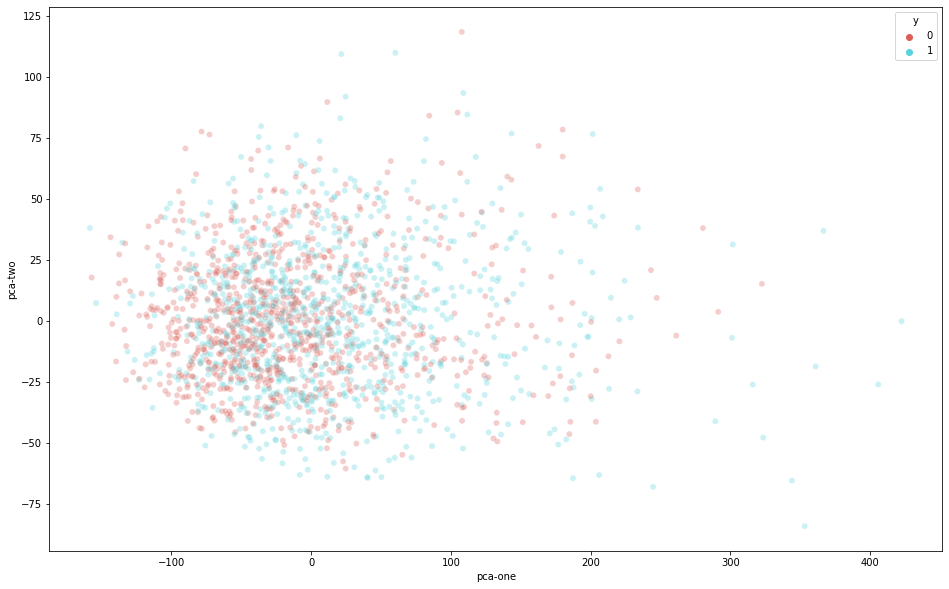

In [ ]:
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="pca-one", y="pca-two",
    hue="y",
    palette=sns.color_palette("hls", 2),
    data=res.loc[rndperm,:],
    legend="full",
    alpha=0.3
)

In [ ]:
last_ft.to_csv("/content/drive/MyDrive/HW3/features_3_2.csv", sep="\t")

## **Part 5. [4 points] Finetune on classification task your new LM model**
-  Finetune on a classification task with BERT-based model you've done in part 4
-  Evaluate yourself by test dataset labels, do not use for train!

### Installs and imports

In [ ]:
!pip install transformers
!pip install datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.2 MB 5.1 MB/s 
     |████████████████████████████████| 84 kB 1.9 MB/s 
     |████████████████████████████████| 6.6 MB 33.5 MB/s 
     |████████████████████████████████| 596 kB 52.1 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 346 kB 4.7 MB/s 
     |████████████████████████████████| 212 kB 7.1 MB/s 
     |████████████████████████████████| 1.1 MB 10.9 MB/s 
     |████████████████████████████████| 140 kB 39.6 MB/s 
     |████████████████████████████████| 86 kB 649 kB/s 
     |████████████████████████████████| 127 kB 22.8 MB/s 
     |████████████████████████████████| 144 kB 26.8 MB/s 
     |████████████████

In [ ]:
!pip install tf-nightly

In [ ]:
import re

import datasets
import torch
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

from transformers import BertTokenizer, BertConfig, BertForTokenClassification
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AdamW, AutoModelForSeq2SeqLM,  AutoModelForTokenClassification, BertModel

from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

import tensorflow as tf
from tensorflow import keras
from dataclasses import dataclass

from pprint import pprint

### Load Dataset

In [ ]:
ds = datasets.load_dataset("imdb")

Reusing dataset imdb (/root/.cache/huggingface/datasets/imdb/plain_text/1.0.0/2fdd8b9bcadd6e7055e742a706876ba43f19faee861df134affd7a3f60fc38a1)


  0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
train, test = ds["train"], ds["test"]
train_data = pd.DataFrame(train)
test_data = pd.DataFrame(test)

In [ ]:
a = test_data.sample(frac=1)
train_data = train_data.sample(frac=1)
test_data = a

In [ ]:
all_data = train_data.append(test_data)

### Model configuration

In [ ]:
@dataclass
class Config:
    MAX_LEN = 256
    BATCH_SIZE = 16
    LR = 0.001
    VOCAB_SIZE = 30000
    EMBED_DIM = 128
    NUM_HEAD = 8  # used in bert model
    FF_DIM = 128  # used in bert model
    NUM_LAYERS = 1


config = Config()

### Data preprocessing

Use the TextVectorization layer to vectorize the text into integer token ids.  
Preprocessing functions:
-  The **get_vectorize_layer** function builds the TextVectorization layer.
-  The **encode** function encodes raw text into integer token ids.
-  The **get_masked_input_and_labels** function will mask input token ids. It masks 15% of all input tokens in each sequence at random.

In [ ]:
def custom_standardization(input_data):
    lowercase = tf.strings.lower(input_data)
    stripped_html = tf.strings.regex_replace(lowercase, "<br />", " ")
    return tf.strings.regex_replace(
        stripped_html, "[%s]" % re.escape("!#$%&'()*+,-./:;<=>?@\^_`{|}~"), ""
    )


def get_vectorize_layer(texts, vocab_size, max_seq, special_tokens=["[MASK]"]):
    """Build Text vectorization layer

    Args:
      texts (list): List of string i.e input texts
      vocab_size (int): vocab size
      max_seq (int): Maximum sequence lenght.
      special_tokens (list, optional): List of special tokens. Defaults to ['[MASK]'].

    Returns:
        layers.Layer: Return TextVectorization Keras Layer
    """
    vectorize_layer = tf.keras.layers.TextVectorization(
        max_tokens=vocab_size,
        output_mode="int",
        standardize=custom_standardization,
        output_sequence_length=max_seq,
    )
    vectorize_layer.adapt(texts)

    # Insert mask token in vocabulary
    vocab = vectorize_layer.get_vocabulary()
    vocab = vocab[2 : vocab_size - len(special_tokens)] + ["[mask]"]
    vectorize_layer.set_vocabulary(vocab)
    return vectorize_layer


vectorize_layer = get_vectorize_layer(
    all_data.text.values.tolist(),
    config.VOCAB_SIZE,
    config.MAX_LEN,
    special_tokens=["[mask]"],
)

# Get mask token id for masked language model
mask_token_id = vectorize_layer(["[mask]"]).numpy()[0][0]


def encode(texts):
    encoded_texts = vectorize_layer(texts)
    return encoded_texts.numpy()


def get_masked_input_and_labels(encoded_texts):
    # 15% BERT masking
    inp_mask = np.random.rand(*encoded_texts.shape) < 0.15
    # Do not mask special tokens
    inp_mask[encoded_texts <= 2] = False
    # Set targets to -1 by default, it means ignore
    labels = -1 * np.ones(encoded_texts.shape, dtype=int)
    # Set labels for masked tokens
    labels[inp_mask] = encoded_texts[inp_mask]

    # Prepare input
    encoded_texts_masked = np.copy(encoded_texts)
    # Set input to [MASK] which is the last token for the 90% of tokens
    # This means leaving 10% unchanged
    inp_mask_2mask = inp_mask & (np.random.rand(*encoded_texts.shape) < 0.90)
    encoded_texts_masked[
        inp_mask_2mask
    ] = mask_token_id  # mask token is the last in the dict

    # Set 10% to a random token
    inp_mask_2random = inp_mask_2mask & (np.random.rand(*encoded_texts.shape) < 1 / 9)
    encoded_texts_masked[inp_mask_2random] = np.random.randint(
        3, mask_token_id, inp_mask_2random.sum()
    )

    # Prepare sample_weights to pass to .fit() method
    sample_weights = np.ones(labels.shape)
    sample_weights[labels == -1] = 0

    # y_labels would be same as encoded_texts i.e input tokens
    y_labels = np.copy(encoded_texts)

    return encoded_texts_masked, y_labels, sample_weights


# We have 25000 examples for training
x_train = encode(train_data.text.values)  # encode reviews with vectorizer
y_train = train_data.label.values
train_classifier_ds = (
    tf.data.Dataset.from_tensor_slices((x_train, y_train))
    .shuffle(1000)
    .batch(config.BATCH_SIZE)
)

# We have 25000 examples for testing
x_test = encode(test_data.text.values)
y_test = test_data.label.values
test_classifier_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(
    config.BATCH_SIZE
)

# Build dataset for end to end model input
test_raw_classifier_ds = tf.data.Dataset.from_tensor_slices(
    (test_data.text.values, y_test)
).batch(config.BATCH_SIZE)

# Prepare data for masked language model
x_all_review = encode(all_data.text.values)
x_masked_train, y_masked_labels, sample_weights = get_masked_input_and_labels(
    x_all_review
)

mlm_ds = tf.data.Dataset.from_tensor_slices(
    (x_masked_train, y_masked_labels, sample_weights)
)
mlm_ds = mlm_ds.shuffle(1000).batch(config.BATCH_SIZE)

### Create BERT model (Pretraining Model) for masked language modeling
BERT-like pretraining model architecture using the MultiHeadAttention layer.  
*token_ids as inputs (including masked tokens) --> correct ids for the masked input tokens*

In [ ]:
def bert_module(query, key, value, i):
    # Multi headed self-attention
    attention_output = tf.keras.layers.MultiHeadAttention(
        num_heads=config.NUM_HEAD,
        key_dim=config.EMBED_DIM // config.NUM_HEAD,
        name="encoder_{}/multiheadattention".format(i),
    )(query, key, value)
    attention_output = tf.keras.layers.Dropout(0.1, name="encoder_{}/att_dropout".format(i))(
        attention_output
    )
    attention_output = tf.keras.layers.LayerNormalization(
        epsilon=1e-6, name="encoder_{}/att_layernormalization".format(i)
    )(query + attention_output)

    # Feed-forward layer
    ffn = keras.Sequential(
        [
            tf.keras.layers.Dense(config.FF_DIM, activation="relu"),
            tf.keras.layers.Dense(config.EMBED_DIM),
        ],
        name="encoder_{}/ffn".format(i),
    )
    ffn_output = ffn(attention_output)
    ffn_output = tf.keras.layers.Dropout(0.1, name="encoder_{}/ffn_dropout".format(i))(
        ffn_output
    )
    sequence_output = tf.keras.layers.LayerNormalization(
        epsilon=1e-6, name="encoder_{}/ffn_layernormalization".format(i)
    )(attention_output + ffn_output)
    return sequence_output


def get_pos_encoding_matrix(max_len, d_emb):
    pos_enc = np.array(
        [
            [pos / np.power(10000, 2 * (j // 2) / d_emb) for j in range(d_emb)]
            if pos != 0
            else np.zeros(d_emb)
            for pos in range(max_len)
        ]
    )
    pos_enc[1:, 0::2] = np.sin(pos_enc[1:, 0::2])  # dim 2i
    pos_enc[1:, 1::2] = np.cos(pos_enc[1:, 1::2])  # dim 2i+1
    return pos_enc


loss_fn = keras.losses.SparseCategoricalCrossentropy(
    reduction=tf.keras.losses.Reduction.NONE
)
loss_tracker = tf.keras.metrics.Mean(name="loss")


class MaskedLanguageModel(tf.keras.Model):
    def train_step(self, inputs):
        if len(inputs) == 3:
            features, labels, sample_weight = inputs
        else:
            features, labels = inputs
            sample_weight = None

        with tf.GradientTape() as tape:
            predictions = self(features, training=True)
            loss = loss_fn(labels, predictions, sample_weight=sample_weight)

        # Compute gradients
        trainable_vars = self.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)

        # Update weights
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))

        # Compute our own metrics
        loss_tracker.update_state(loss, sample_weight=sample_weight)

        # Return a dict mapping metric names to current value
        return {"loss": loss_tracker.result()}

    @property
    def metrics(self):
        # We list our `Metric` objects here so that `reset_states()` can be
        # called automatically at the start of each epoch
        # or at the start of `evaluate()`.
        # If you don't implement this property, you have to call
        # `reset_states()` yourself at the time of your choosing.
        return [loss_tracker]


def create_masked_language_bert_model():
    inputs = tf.keras.layers.Input((config.MAX_LEN,), dtype=tf.int64)

    word_embeddings = tf.keras.layers.Embedding(
        config.VOCAB_SIZE, config.EMBED_DIM, name="word_embedding"
    )(inputs)
    position_embeddings = tf.keras.layers.Embedding(
        input_dim=config.MAX_LEN,
        output_dim=config.EMBED_DIM,
        weights=[get_pos_encoding_matrix(config.MAX_LEN, config.EMBED_DIM)],
        name="position_embedding",
    )(tf.range(start=0, limit=config.MAX_LEN, delta=1))
    embeddings = word_embeddings + position_embeddings

    encoder_output = embeddings
    for i in range(config.NUM_LAYERS):
        encoder_output = bert_module(encoder_output, encoder_output, encoder_output, i)

    mlm_output = tf.keras.layers.Dense(config.VOCAB_SIZE, name="mlm_cls", activation="softmax")(
        encoder_output
    )
    mlm_model = MaskedLanguageModel(inputs, mlm_output, name="masked_bert_model")

    optimizer = keras.optimizers.Adam(learning_rate=config.LR)
    mlm_model.compile(optimizer=optimizer)
    return mlm_model


id2token = dict(enumerate(vectorize_layer.get_vocabulary()))
token2id = {y: x for x, y in id2token.items()}


class MaskedTextGenerator(keras.callbacks.Callback):
    def __init__(self, sample_tokens, top_k=5):
        self.sample_tokens = sample_tokens
        self.k = top_k

    def decode(self, tokens):
        return " ".join([id2token[t] for t in tokens if t != 0])

    def convert_ids_to_tokens(self, id):
        return id2token[id]

    def on_epoch_end(self, epoch, logs=None):
        prediction = self.model.predict(self.sample_tokens)

        masked_index = np.where(self.sample_tokens == mask_token_id)
        masked_index = masked_index[1]
        mask_prediction = prediction[0][masked_index]

        top_indices = mask_prediction[0].argsort()[-self.k :][::-1]
        values = mask_prediction[0][top_indices]

        for i in range(len(top_indices)):
            p = top_indices[i]
            v = values[i]
            tokens = np.copy(sample_tokens[0])
            tokens[masked_index[0]] = p
            result = {
                "input_text": self.decode(sample_tokens[0].numpy()),
                "prediction": self.decode(tokens),
                "probability": v,
                "predicted mask token": self.convert_ids_to_tokens(p),
            }
            pprint(result)


sample_tokens = vectorize_layer(["I have watched this [mask] and it was awesome"])
generator_callback = MaskedTextGenerator(sample_tokens.numpy())

bert_masked_model = create_masked_language_bert_model()
bert_masked_model.summary()

Model: "masked_bert_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 256)]        0           []                               
                                                                                                  
 word_embedding (Embedding)     (None, 256, 128)     3840000     ['input_3[0][0]']                
                                                                                                  
 tf.__operators__.add_6 (TFOpLa  (None, 256, 128)    0           ['word_embedding[0][0]']         
 mbda)                                                                                            
                                                                                                  
 encoder_0/multiheadattention (  (None, 256, 128)    66048       ['tf.__operators_

### Training MLM

In [ ]:
bert_masked_model.fit(mlm_ds, epochs=20, callbacks=[generator_callback])

Epoch 1/20
3125/3125 [==============================] - ETA: 0s - loss: 6.9238{'input_text': 'i have watched this [mask] and it was awesome',
 'predicted mask token': 'this',
 'prediction': 'i have watched this this and it was awesome',
 'probability': 0.08243156}
{'input_text': 'i have watched this [mask] and it was awesome',
 'predicted mask token': 'i',
 'prediction': 'i have watched this i and it was awesome',
 'probability': 0.073076196}
{'input_text': 'i have watched this [mask] and it was awesome',
 'predicted mask token': 'a',
 'prediction': 'i have watched this a and it was awesome',
 'probability': 0.047685966}
{'input_text': 'i have watched this [mask] and it was awesome',
 'predicted mask token': 'movie',
 'prediction': 'i have watched this movie and it was awesome',
 'probability': 0.039134607}
{'input_text': 'i have watched this [mask] and it was awesome',
 'predicted mask token': 'it',
 'prediction': 'i have watched this it and it was awesome',
 'probability': 0.02871476

Save our MLM for further usage

In [ ]:
bert_masked_model.save("bert_mlm_imdb_20_last.h5")

### Fine-tune a sentiment classification model
Fine-tune our self-supervised model on a downstream task of sentiment classification.  
Create a classifier:
-  add a Pooling layer and a Dense layer on top of the pretrained BERT features.

In [ ]:
# Load pretrained bert model
mlm_model = keras.models.load_model(
    "/content/bert_mlm_imdb_20_last.h5", custom_objects={"MaskedLanguageModel": MaskedLanguageModel}
)
pretrained_bert_model = tf.keras.Model(
    mlm_model.input, mlm_model.get_layer("encoder_0/ffn_layernormalization").output
)

# Freeze it
pretrained_bert_model.trainable = False


def create_classifier_bert_model():
    inputs = tf.keras.layers.Input((config.MAX_LEN,), dtype=tf.int64)
    sequence_output = pretrained_bert_model(inputs)
    pooled_output = tf.keras.layers.GlobalMaxPooling1D()(sequence_output)
    hidden_layer = tf.keras.layers.Dense(64, activation="relu")(pooled_output)
    outputs = tf.keras.layers.Dense(1, activation="sigmoid")(hidden_layer)
    classifer_model = keras.Model(inputs, outputs, name="classification")
    optimizer = keras.optimizers.Adam()
    classifer_model.compile(
        optimizer=optimizer, loss="binary_crossentropy", metrics=["accuracy"]
    )
    return classifer_model


classifer_model = create_classifier_bert_model()
classifer_model.summary()

# Train the classifier with frozen BERT stage
classifer_model.fit(
    train_classifier_ds,
    epochs=10,
    validation_data=test_classifier_ds,
)

# Unfreeze the BERT model for fine-tuning
pretrained_bert_model.trainable = True
optimizer = keras.optimizers.Adam()
classifer_model.compile(
    optimizer=optimizer, loss="binary_crossentropy", metrics=["accuracy"]  #SparseCategoricalCrossentropy
)
classifer_model.fit(
    train_classifier_ds,
    epochs=10,
    validation_data=test_classifier_ds,
)

Model: "classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 256)]             0         
                                                                 
 model_3 (Functional)        (None, 256, 128)          3939584   
                                                                 
 global_max_pooling1d_2 (Glo  (None, 128)              0         
 balMaxPooling1D)                                                
                                                                 
 dense_8 (Dense)             (None, 64)                8256      
                                                                 
 dense_9 (Dense)             (None, 1)                 65        
                                                                 
Total params: 3,947,905
Trainable params: 8,321
Non-trainable params: 3,939,584
______________________________________

Create an end-to-end model that incorporates the TextVectorization layer, and let's evaluate.  
Our model will accept raw strings as input.

In [ ]:
def get_end_to_end(model):
    inputs_string = keras.Input(shape=(1,), dtype="string")
    indices = vectorize_layer(inputs_string)
    outputs = model(indices)
    end_to_end_model = keras.Model(inputs_string, outputs, name="end_to_end_model")
    optimizer = keras.optimizers.Adam(learning_rate=config.LR)
    end_to_end_model.compile(
        optimizer=optimizer, loss="binary_crossentropy", metrics=["accuracy"]
    )
    return end_to_end_model


end_to_end_classification_model = get_end_to_end(classifer_model)
end_to_end_classification_model.evaluate(test_raw_classifier_ds)

1563/1563 [==============================] - 11s 7ms/step - loss: 0.2137 - accuracy: 0.9538


[0.2136968970298767, 0.9538000226020813]

In [ ]:
preds = end_to_end_classification_model.predict(test_raw_classifier_ds)

In [ ]:
preds

array([[1.2436466e-08],
       [1.4999172e-02],
       [2.8681828e-04],
       ...,
       [9.9984980e-01],
       [6.8496079e-03],
       [9.9979180e-01]], dtype=float32)

In [ ]:
result = np.where(preds > 0.5, 1,0)

In [ ]:
result

array([[0],
       [0],
       [0],
       ...,
       [1],
       [0],
       [1]])

## Kaggle Submission

In [ ]:
import pandas as pd
from natsort import natsorted

In [ ]:
res = pd.read_csv("/content/drive/MyDrive/HW3/bert_classifier.csv", sep="\t")

In [ ]:
res = res.drop(["Unnamed: 0"], axis=1)

In [ ]:
res = res.drop(["text"], axis=1)

In [ ]:
res.columns = ['Predicted']


In [ ]:
res["Id"] = res.index.values

In [ ]:
res = res.reindex(natsorted(res.columns), axis=1)

In [ ]:
res["Predicted"] = result

In [ ]:
res

,Id,Predicted
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0
...,...,...
24995,24995,1
24996,24996,1
24997,24997,1
24998,24998,0


In [ ]:
res.to_csv("sumission_MLM_2.csv", index=False)

## **Part 6. [2 point] Results**

IMDB dataset having 50K movie reviews for natural language processing or Text analytics. Dataset is well balanced. As it's shown on plots the dataset is perfectly balanced with equal number of reviews text for the two classes.  
0 - negative and 1 - positive.  
We can see that most of the sentences are around 700 - 1000 characters long, which is pretty obvious. However, few sentences are shorter and few even long as 6000 characters.  
This is a good, very versatile Review Dataset.

**Explore the data**  
3D gives a weak idea of the distribution of classes, and in 2D, although bad, the dependence is captured. tSNE does not capture the division into classes in any way, but at the same time it highlights some clusters. Perhaps with a different markup of labels or simple learning without a teacher, we could highlight, for example, the topics of reviews by genre. This question requires additional study and is not included in our task.

**Logistic Regression and SVM**  
As it was expected, even using BERT embedding as features, performance of basic models is lower then transformers.  
I've decided not experiment a lot with Grid Search for best params and search for better features for linear models, so the best score here is 0.68.  

**BERT Classifier**  
Our classifier is based on *\"bert-base-cased"* model. Huge text preprocessing is not very important, because BERT have been trained on Wiki materials. 
For fine-tuning hyperparameters we were using BERT authors recommendations:

-  Batch size: 16, 32
-  Learning rate (Adam): 5e-5, 3e-5, 2e-5
-  Number of epochs: 2, 3, 4  

Our MAX_LEN was only 200 tokens for not consuming much resources, but even so score is 0.90. Quiete simple and efficient.  

**Masked LM**  
Fine-tuned with MLM BERT — great for domain-specific use and to train a language model in a self-supervised setting.  
As we can see, our model is very close to theme of dataset after mask train, it predicts "movie", "film", "show" for test [MASKED] word.
For this step we created BERT-like pretraining model architecture using the MultiHeadAttention layer.  
For classification step we fine-tuned our self-supervised model on a downstream task of sentiment classification:
-  add a pooling layer and a Dense layer on top of the pretrained BERT features.

Usage of max lengh = 512, and BERT model fine-tuned with 20 epochs, and the fine-tuned classifier with unfreezed BERT model weights gived us best result in submission 0.95.
